# Compressed sensing project : study of non-negative matrix factorization and online dictionary learning



## Introduction: some definitions
### - Dictionary learning:
Let us consider a set X = [x
1
, . . . , x
n] ∈ R
m×n of n
signals of dimension m. Dictionary learning is a matrix
factorization problem that aims to represent these signals
as linear combinations of dictionary elements, denoted here
by the columns of a matrix D = [d
1
, . . . , d
p
] ∈ R
m×p
.
More precisely, the dictionary D is learned along with a
matrix of decomposition coefficients A = [α1
, . . . , αn] ∈
R
p×n, so that x
i ≈ Dαi
for every signal x
i
, as measured
by any convex loss, e.g., the square loss in this paper


### - Sparse PCA:
It is useful to distinguish two conceptually different interpretations
of PCA. In terms of analysis, PCA sequentially
projects the data on subspaces that explain the largest fraction
of the variance of the data. In terms of synthesis, PCA
finds a basis, or orthogonal dictionary, such that all signals
observed admit decompositions with low reconstruction
error. These two interpretations recover the same basis
of principal components for PCA but lead to different
formulations for sparse PCA.

## Online group-structured dictionary learning = Dictionary learning (=Matrix Factorization) + Structured sparse coding

Dictionary learning = Dictionary is fixed and known.
When combining dictionary learning and structured sparse coding, we want to learn the structure of the dictionary, e.g. alternating minimization of the dictionary.


### 4 problems to solve:
1. online algorithm
2. enables general overlapping group structures
3. applies non-convex sparsity inducing regularization
4. can deal with missing information

In [2]:
import numpy as np
import pandas as pd
import cvxopt

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as lin

In [204]:
from sklearn.metrics import mean_squared_error

## First part : non-negative matrix factorization

We wanted here to study Seung & Lee's "Algorithms for Non-negative Matrix Factorization" paper. They propose two types of non-negative factorization (NMF) : one that minimizes a least-squares distance and one that minimizes the Kullback-Leibler divergence (in the case that our initialization matrix is a probability matrix).

__Least square NMF__

Here is the problem setting:

Given a matrix $V$ living in $\mathbb{R}^{n,m}$ we want to find matrices $W\in\mathbb{R}^{n,k}$ and $H\in\mathbb{R}^{k,m}$ solutions of the following minimization problem:

$$
\text{minimize }||V-WH||^2\text{ under constraints } W,H>0
$$


The algorithm, similarly to a classical gradient descent, will start with random W and H. Then we will apply the following update rules allowing us to converge to a local minima (the problem is non convex w.r.t. W,H).

$$
H \leftarrow H\odot(W^TV)\oslash(W^TWH)
$$

$$
W \leftarrow W\odot(VH^T)\oslash(WHH^T)
$$

With $\odot$ standing for element-wise product and $\oslash$ standing for element-wise division

In [4]:
def update_h(V,W,H):
    factor1 = np.dot(W.T,V)
    factor2 = np.dot(np.dot(W.T,W),H)
    return H*factor1/factor2

In [5]:
def update_w(V,W,H):
    factor1 = np.dot(V,H.T)
    factor2 = np.dot(W,np.dot(H,H.T))
    return W*factor1/factor2
        

In [6]:
def error(V,W,H):
    return lin.norm(V-np.dot(W,H))

In [7]:
def non_negative_threshold(Z):
    neg_coefs = Z<0
    Z[neg_coefs] = 0
    return Z

In [8]:
def solver(V,W,H,t=100,verbose=False):
    err=[]
    for i in range(t):
        W_new = update_w(V,W,H)
        W = W_new
        H_new = update_h(V,W,H)
        H = H_new
        if verbose==True:
            print error(V,W,H)
        err.append(error(V,W,H))
    
    return W,H,err

In [84]:
from sklearn.datasets import fetch_lfw_people
dataset = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
V = dataset.data

n,m = V.shape
k = 150
iterations = 500
H = non_negative_threshold(15+np.random.randn(k, m))
W = non_negative_threshold(15+np.random.randn(n, k))

In [24]:
W,H,err = solver(ratings,W,H,iterations)

KeyboardInterrupt: 

In [86]:
def plot_faces(faces, n_rows=4, n_cols=8, label=True):
    plt.figure(figsize=(14, 10))
    n_rows, n_cols = 4, 8
    face_shape = (50, 37)
    for k, flat_face in enumerate(faces):
        if k >= n_rows * n_cols:
            break
        face = flat_face.reshape(face_shape)
        plt.subplot(n_rows, n_cols, k+1)
        plt.imshow(face, cmap=plt.cm.gray, interpolation='none')
        plt.xticks(())
        plt.yticks(())
        if label:
            plt.title(target_names[y[k]], size=10)

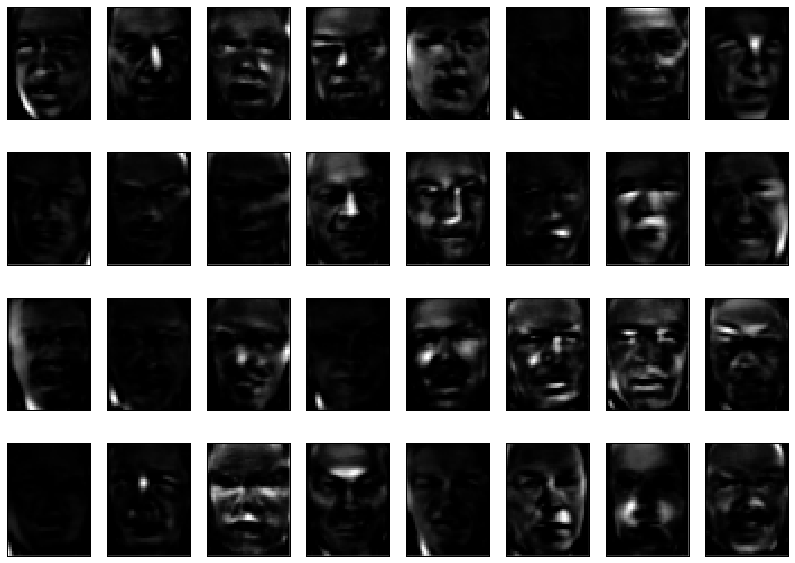

In [87]:
plot_faces(H,label=False)

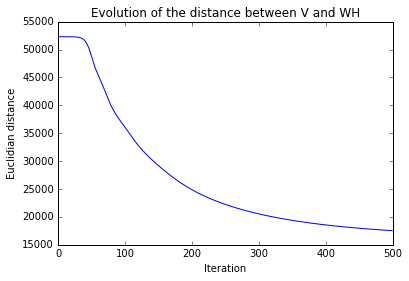

In [88]:
plt.plot(np.arange(len(err)),err)
plt.xlabel("Iteration")
plt.ylabel("Euclidian distance")
plt.title("Evolution of the distance between V and WH")

__Kullback-Leibler NMF__

Here the problem setting is similar, the only diference resides in the distance minimized:

Given a matrix $V$ living in $\mathbb{R}^{n,m}$ we want to find matrices $W\in\mathbb{R}^{n,k}$ and $H\in\mathbb{R}^{k,m}$ solutions of the following minimization problem:

$$
\text{minimize }KL(V,WH)\text{ under constraints } W,H>0
$$


Here again, Lee and Seung propose a multiplicative update rule rewritten using a similar paper "MULTIPLICATIVE UPDATE RULES FOR NONNEGATIVE MATRIX FACTORIZATION WITH CO-OCCURRENCE CONSTRAINTS" (http://sig.umd.edu/publications/Tjoa_ICASSP2_201003.pdf)

$$
H \leftarrow H\odot \frac{W^T\frac{V}{WH}}{W^T\mathbb{1}^n}
$$

$$
W \leftarrow W\odot \frac{\frac{V}{WH}H^T}{\mathbb{1}^mH^T}
$$

with $\odot$ the element-wise matrix product and $\hline$ the element-wise division.

In [107]:
def update_h(V,W,H):
    n,m = V.shape
    unit_vector = np.ones((n,m))
    factor1 = np.dot(W.T,V/np.dot(W,H))
    factor2 = np.dot(W.T,unit_vector)
    return H*factor1/factor2

def update_w(V,W,H):
    n,m = V.shape
    unit_vector = np.ones((n,m))
    factor1 = np.dot(V/np.dot(W,H),H.T)
    factor2 = np.dot(unit_vector,H.T)
    return W*factor1/factor2

def normalize(Z):
    norm = Z.sum(axis=1).sum()
    Z_new = Z.astype(float)/norm
    return Z_new


In [124]:
from sklearn.datasets import fetch_lfw_people
dataset = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
V = dataset.data

n,m = V.shape
k = 150
iterations = 50
H = non_negative_threshold(15+np.random.randn(k, m))
W = non_negative_threshold(15+np.random.randn(n, k))
V = normalize(V) #Here it is compulsory to renormalize V so that the sum of its coefficients equals 1 (V should be a propability matrix)

In [120]:
W,H,err = solver(V,W,H,iterations,verbose=True)

0.000166000538623
0.00016599960582
0.00016599864543
0.000165997641692
0.000165996575503
0.000165995425246
0.000165994165882
0.000165992767885
0.000165991195946
0.000165989407394
0.000165987350256
0.00016598496085
0.000165982160788
0.000165978853254
0.000165974918331
0.000165970207185
0.000165964534761
0.000165957670667
0.000165949327746
0.000165939147806
0.000165926683783
0.000165911377503
0.000165892532001
0.000165869277186
0.000165840527403
0.000165804929261
0.000165760797952
0.00016570604022
0.000165638062375
0.000165553662288
0.000165448905592
0.000165318988623
0.00016515809451
0.000164959254999
0.000164714239715
0.000164413507238
0.000164046268351
0.000163600729504
0.000163064598878
0.000162425939205
0.000161674425522
0.000160802993835
0.00015980973454
0.000158699699809
0.000157486107483
0.000156190338047
0.000154840263034
0.000153466880303
0.000152099869474
0.000150763235459


In [123]:
np.dot(W,H).sum(axis=0).sum()

0.99999999993112687

# Jester database

In [210]:
xl = pd.ExcelFile('jester-data-1.xls')

In [211]:
xl.sheet_names

[u'jester-data-1-new']

In [212]:
df = xl.parse('jester-data-1-new', header = None)

In [213]:
nb_jokes_user = df[0]

In [214]:
del df[0]

In [215]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [216]:
n_users = df.shape[0]
n_items = df.shape[1]
print str(n_users) + ' users'
print str(n_items) + ' items'

24983 users
100 items


In [217]:
ratings = np.array(df)

In [218]:
ratings

array([[ -7.82,   8.79,  -9.66, ...,  99.  ,  99.  ,  99.  ],
       [  4.08,  -0.29,   6.36, ...,   0.34,  -4.32,   1.07],
       [ 99.  ,  99.  ,  99.  , ...,  99.  ,  99.  ,  99.  ],
       ..., 
       [ 99.  ,  99.  ,  99.  , ...,  99.  ,  99.  ,  99.  ],
       [ 99.  ,  99.  ,  99.  , ...,  99.  ,  99.  ,  99.  ],
       [  2.43,   2.67,  -3.98, ...,  99.  ,  99.  ,  99.  ]])

# Second part: Online Structured Dictionary Learning

## 3. CF

In [35]:
d_alpha = 100

In [38]:
ratings.shape

(24983L, 100L)

In [222]:
## Partition the ratings into train / validation set
R_train = ratings[:10000]
R_val = ratings[10000:20000]
R_test = ratings[20000:]

In [223]:
R_test.shape

(4983L, 100L)

# Initialisation de l'entrée dans l'algo

## On initialise D, $\alpha$, etc. 

In [238]:
### Initlialize of parameters 
D = np.random.randn(d_x,d_alpha)
alpha = np.random.randn(d_alpha)
T_alpha = 5
epsilon = 10**(-5)
eta = 0.5
kappa = 1. / (2**10)
#d_G = np.ones(d_alpha)
d_G = group_structure(d_alpha, struct='lasso', nb_group=10)

In [240]:
d_G[0]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [241]:
alpha

array([ 1.24618675, -0.44025293,  0.31052356, -0.44436276,  0.39072999,
        1.38097852,  0.6865351 ,  0.06067157,  1.22770667, -0.34496713,
       -2.19584973,  2.01878237,  2.53725374,  1.13965004,  0.340518  ,
        1.33068438, -0.66236244, -0.64097486,  1.03704006, -1.0566791 ,
        0.18576491,  2.217863  , -1.37539204,  0.61226934,  0.74908406,
        1.85218612,  0.83894947, -0.24619774, -0.05328985, -1.1091567 ,
       -0.5463071 , -0.88432155,  2.4599541 , -1.46291005, -0.32012143,
        1.74793316,  0.65256059, -1.00530462, -1.10265767, -0.07016784,
       -0.60402397,  0.04367416, -0.28297634, -1.61759365,  0.49716357,
       -0.97946526,  2.56169443, -0.02270301,  0.50339582, -0.17284325,
        0.1692232 , -1.20428179, -0.78678755, -2.32792899, -1.67119879,
        0.76409355,  0.16320885,  0.75043187,  0.46925164, -0.63203155,
       -1.57011556,  0.7033537 ,  0.66140206,  0.10451633,  0.23762245,
        0.54114941, -0.98130388,  1.17361088, -0.18407816, -2.02

## On extrait $x_O$ de $x$, $D_O$ de $D$

In [242]:
## Take 1st row of R_train
x = list(R_train[0].copy())

## Save indexes of observed values
indices = [i for i, item in enumerate(x) if item != 99]

#remove missing values of first row of R_train
x_O = [a for a in x if a != 99]

# save the observed rows of D
D_O = D[np.array(indices),:].copy() 

In [237]:
def min_alpha(x_O, D_O, alpha, eta, d_alpha, T_alpha, epsilon, d_G):
    ## Minimisation on alpha
    for t in range(T_alpha):

        ## Compute z
        norm_G_alpha = []

        for j in d_G:
            norm_G_alpha.append(np.linalg.norm(j * alpha, ord =2))
        coef = (np.linalg.norm(norm_G_alpha, ord = eta) ** (eta - 1))

        norm_G_alpha = np.array(norm_G_alpha)
        norm_G_alpha = np.power(norm_G_alpha, 2 - eta)
        z = norm_G_alpha * coef
        for i, item in enumerate(z):
            z[i] = max(item, epsilon)

        
        ## Compute alpha
        ksi = []
        for j in range(d_alpha):
            coef_ksi = 0.0
            for i, item in enumerate(z):
                coef_ksi += (d_G[i][j])**2 / item 
            ksi.append(coef_ksi)
        
        ### Pour résoudre le pb de progammation quadratique, on utilise cvxopt
        # P = kappa * diag(ksi) + D_O.T.dot(D_O)
        # Q = - D_O.T.dot(x_O)
        P = kappa * np.diag(ksi) + D_O.T.dot(D_O)
        P = cvxopt.matrix(P)

        q = - D_O.T.dot(x_O)
        q = cvxopt.matrix(q)

        sol = cvxopt.solvers.qp(P,q)
        alpha = np.ravel(sol['x'])
    return alpha

In [243]:
alpha = min_alpha(x_O, D_O, alpha, eta, d_alpha, T_alpha, epsilon, d_G)

In [244]:
alpha

array([ -4.42423503e-03,   7.73132758e-01,  -1.92842830e-03,
         6.39557785e-01,   8.44078406e-01,   1.65145383e+00,
        -2.02564547e+00,  -1.38509686e+00,   2.55241164e+00,
         3.58248673e+00,   2.14158321e-01,   1.39804015e+00,
         1.21190967e+00,   1.19172084e-02,  -7.39976438e-01,
        -8.84294653e-01,  -2.61427167e+00,  -9.83050675e-01,
         3.04163367e+00,  -8.99400128e-02,  -1.20852488e-03,
        -2.16870925e-03,   3.13649581e+00,  -7.44198137e-01,
        -2.06542475e-03,  -2.38728310e-01,   1.31282960e+00,
        -6.23508621e-01,   8.72839144e-01,   1.22546233e+00,
         6.13006627e-01,  -1.77600661e+00,  -3.69670619e-01,
         1.35573352e-01,  -8.35067040e-03,   1.52061564e+00,
         1.03232727e+00,  -5.54533526e-01,   1.93495981e+00,
         1.61971959e-02,   2.57337339e+00,   3.58793363e-01,
         9.93485401e-01,  -1.34915583e-02,   2.51974941e+00,
        -1.50184326e+00,  -7.60379104e-01,  -6.34946053e-03,
        -2.33953169e+00,

In [247]:
def testing_model(D, alpha, nb_items_to_remove, R_test, model = 'NMF', missing_value = 99):
    ## Define testing set
    # On définit le testing set, on fait la prédiction et on calcule l'erreur dans 1 même boucle
    
    N = R_test.shape[0]
    MSE = 0.0
    #if model == 'NMF':
     #   XXXXXXXX
    if model == 'OSDL':
        for j, jtem in enumerate(R_test):
            ## Take 1st row of R_train
            x = jtem.copy()

            ## Save indexes of observed values
            indices = [i for i, item in enumerate(x) if item != missing_value]
            indices = np.array(indices)

            # save the observed rows of D
            # we will use for prediction of x_O_pred and compare it to x_O
            D_O_test = D[np.array(indices),:].copy() 

            #remove missing values of first row of R_train
            x_O_test = x[indices]

            #remove nb_items_to_remove values of x_O_test
            index_pred = sorted(np.random.choice(len(x_O_test), len(x_O_test) - nb_items_to_remove, replace = False))
            x_O_pred = x_O_test[index_pred].copy()
            D_O_pred = D[index_pred,:].copy()

            #prediction
            alpha_test = min_alpha(x_O_pred, D_O_pred, alpha, eta, d_alpha, T_alpha, epsilon, d_G)

            MSE += mean_squared_error(x_O_test, D_O_test.dot(alpha_test))

        MSE = MSE / N
        RMSE = np.sqrt(MSE)
    return 'MSE: ',MSE, ' RMSE: ', RMSE
        
    

In [248]:
testing_model(D, alpha, 10, R_test, model = 'OSDL', missing_value = 99)

('MSE: ', 45.483075883048855, ' RMSE: ', 6.744114165926379)

In [34]:
## Define similarities

# Normalized scalar product based similarity
def item_similarity_1(q_i, q_j, alpha):
    a = (q_i ).T.dot(q_j)
    b = q_i.T.dot(q_i)
    c = q_j.T.dot(q_j)
    
    s_ij = (max(0, a) / np.sqrt(b * c))** alpha
    
    return s_ij

# Normalized Euclidian distance based similarity
def item_similarity_2(q_i, q_j, alpha):
    a = (q_i - q_j).T.dot(q_i - q_j)
    b = q_i.T.dot(q_i)
    c = q_j.T.dot(q_j)
    
    s_ij = (a / np.sqrt(b * c))**(- alpha)
    
    return s_ij

In [228]:
def group_structure(d_alpha, struct, nb_group=3):
    if struct == 'lasso':
        d_G = []
        for i in range(d_alpha):
            G = np.zeros(d_alpha)
            G[i] = 1
            d_G.append(G)
            
    if struct == 'group_lasso':
        # fonction rand pour donner le nombre d'indices dans chaque partition de {1...d_alpha}
        # Exemple: n paritions
        partition = sorted(np.random.choice(d_alpha, nb_group-1, replace = False))

        ## shuffle les indices
        shuffled_indices = np.random.choice(d_alpha, d_alpha, replace = False)
        
        ## Création des groupes
        x = []
        for i, item in enumerate(partition):
            if i == 0:
                x.append(shuffled_indices[:item])
            elif i == len(partition) - 1:
                x.append(shuffled_indices[partition[i-1]:item])
                x.append(shuffled_indices[item:])
            else:
                x.append(shuffled_indices[partition[i-1]: item])
        d_G = []
        for i, item in enumerate(x):
            G = np.zeros(d_alpha)
            G[item] = 1
            d_G.append(G)
            
    return d_G
    

In [230]:
group_structure(d_alpha, struct='lasso', nb_group=3)[0]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])